# Algoritmo 1 (Fudidasso)

In [2]:
%matplotlib inline

import numpy as np
import numpy.random as rng
import pandas as pd
import statsmodels.api as sm
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm
from scipy.stats import multivariate_normal, invgamma
from scipy.stats import norm, uniform
from statsmodels.tsa.statespace.tools import is_invertible
from statsmodels.graphics.tsaplots import plot_acf
from IPython.display import clear_output

sns.set()

In [3]:
# Importando a série do Ibovespa
df = pd.read_csv('ibov.csv', sep=';', encoding='utf-8-sig', index_col=0)

# data para datetime
df['Data/Hora'] = pd.to_datetime(df['Data/Hora'], format='%d/%m/%Y')

# df.set_index('Data/Hora')['Cotação'].plot(kind='line', figsize=(16,4), 
#                                           title='Ibovespa 16/11/2006 - 14/11/2019')

In [4]:
ibov = df.set_index('Data/Hora')['Cotação'].sort_index(ascending=True)
log_ibov = np.log(ibov).diff()[1:] 

# Plot the series to see what it looks like
# fig, ax = plt.subplots(figsize=(13, 3), dpi=300)
# ax.plot(log_ibov, label=r'$\Delta \log Ibov$')
# ax.set_title(r'$\Delta \log Ibov$')
# ax.yaxis.grid(b=True);

In [5]:
# y = log-retorno corrigido pela média
# y = 100*(log_ibov - np.cumsum(log_ibov)/np.array(range(1,len(ibov))))[:1000]
y = 100*(log_ibov - np.mean(log_ibov))[:1000]

<br>

## Algoritmo base: Gibbs-Sampler

No paper original (Kim, Shephard e Chib - 1998), foram executadas 1.000.000 iterações, com um *burn-in* de 50.000 observações.

### Amostrando de ht | theta, y, h\t

In [5]:
def h_star(mu, phi, h_antes, h_depois):
    return mu + (phi*((h_antes - mu)+(h_depois-mu)))/(1+phi**2)

In [6]:
def mu_t(mu, sigma2_n, phi, h_antes, h_depois, y_agora):
    hs = h_star(mu, phi, h_antes, h_depois)
    v = v2(sigma2_n, phi)
    return hs + (v/2)*((y_agora**2)*np.exp(-hs) - 1)

def v2(sigma2_n,phi):
    return sigma2_n/(1+phi**2)

In [7]:
def f_star(y_agora, h_agora):
    return np.exp(-0.5*h_agora - (((y_agora**2)/2) * np.exp(-h_agora)))

def g_star(y_agora, h_agora, mu, phi, h_antes, h_depois):
    hs = h_star(mu, phi, h_antes, h_depois)
    return np.exp(-0.5*h_agora - (((y_agora**2)/2)*(np.exp(-hs)*(1+hs) - h_agora*np.exp(-hs))))

In [8]:
def g(phi, h1, mu, s2_n):
    priori_phi = np.log(stats.beta.pdf(phi, 1.5, 20))
#     priori_phi = 1
    return priori_phi - (((h1 - mu)**2)*(1-phi**2)/(2*s2_n)) + 0.5*np.log(1-phi**2)    
    

### Amostrando de $\sigma^2_n \mid y, h,\phi, \mu$

In [9]:
T = len(y)
N = 500

h = np.zeros(N*T).reshape(N,T)
phi = np.zeros(N).reshape(N)
s2_n = np.zeros(N).reshape(N)
mu = np.zeros(N).reshape(N)
beta = np.zeros(N).reshape(N)

# valores iniciais
phi[0] = 0.95
s2_n[0] = 0.02
# mu[0] = np.random.normal(loc=0, scale=10, size=1)  # N(0,10)
mu[0] = 0
beta[0] = np.exp(mu[0]/2)

# valores para calcular s2_n
sigma_r = 5
S_sigma = 0.01 * sigma_r

In [13]:
for i in range(N-1):
    ### Passo 2: amostrando de h (AJUSTAR O h)
    for t in range(1,T-1):
        m = mu_t(mu[i],s2_n[i],phi[i], h[i][t-1],h[i][t+1],y[t])
        v = v2(s2_n[i], phi[i])
        
        acc = 1
        while acc>0:
            h_prop = np.random.normal(loc=m, scale=np.sqrt(v), size=1)[0]
            h_prop1 = mu[i] + phi[i]*(h_prop-mu[i])  # falta termo aleatório

            alpha = f_star(y[t],h_prop)/g_star(y[t],h_prop, mu[i], phi[i], h[i][t-1], h_prop1)
            if alpha > np.random.uniform() :
                h[i][t] = h_prop
                acc = 0

    
#     print('cheguei aqui')
    ### Passo 3:  amostrando s2_n de p(s2_n|h,y,mu,phi)
    a = (T + sigma_r)
    # calcula soma_t=1^n (h_t+1 - mu)-phi(h_t-mu)^2
    soma = []
    for t in range(1,T-1):
        soma.append(((h[i][t+1] - mu[i])-phi[i]*(h[i][t] - mu[i]))**2) # termos do somatório   
    b = S_sigma + (h[i][0] - mu[i])**2 * (1-phi[i]**2) + np.sum(soma)
    s2_n[i+1] = invgamma.rvs(a/2, scale= b/2)

    ### Passo 4: amostrando phi de p(phi | h,y,mu,s2_n)
    soma0 = []
    soma1 = []
    for t in range(T-1):
        soma0.append((h[i][t+1] - mu[i])*(h[i][t]-mu[i]))
        soma1.append((h[i][t] - mu[i])**2)

    phi_hat = np.sum(soma0)/np.sum(soma1)
    
    v_phi = s2_n[i+1] / np.sum(soma1)**2
    phi_prop = np.random.normal(loc=phi_hat, scale=np.sqrt(v_phi), size=1)[0]

    gamma = np.exp(g((phi_prop+1)/2, h[i][0], mu[i], s2_n[i+1]) - g((phi[i]+1)/2, h[i][0], mu[i], s2_n[i+1]))
    if np.random.uniform() < gamma:
        phi[i+1] = phi_prop
    else:
        phi[i+1] = phi[i]

    ### Passo 5: amostrando mu de p(mu|h,y,phi,s2_n)
    s = s2_n[i+1]/((T-1)*(1-phi[i+1])**2 + (1-phi[i+1]**2))
    soma = []
    for t in range(T-1):
        soma.append(h[i][t+1] - phi[i+1]*h[i][t])

    m = s * ((1-phi[i+1]**2)*h[i][0]/s2_n[i+1] + ((1-phi[i+1])/s2_n[i+1] * np.sum(soma)))
    mu[i+1] = np.random.normal(loc=m, scale=np.sqrt(s), size=1)[0]
    beta[i+1] = np.exp(mu[i+1]/2)

#     print(s2_n[i+1], phi[i+1], mu[i+1])

  0%|          | 0/499 [00:08<?, ?it/s]


KeyboardInterrupt: 

https://cran.r-project.org/web/packages/stochvol/vignettes/article.pdf

http://hedibert.org/wp-content/uploads/2013/12/sv-ar1-routines.R.txt

http://hedibert.org/wp-content/uploads/2013/12/sv-ar1.R.txt

http://hedibert.org/monte-carlo-methods-and-stochastic-volatility/

https://cran.r-project.org/web/packages/stochvol/stochvol.pdf

In [6]:
def draw_posterior_mu(T, states, phi, sigma2):
    sigma2_mu = sigma2 / ((T - 1) * (1 - phi)**2 + (1 - phi**2))

    tmp1 = ((1 - phi**2) / sigma2) * states[0]
    tmp = ((1 - phi) / sigma2) * np.sum(states[1:] - phi * states[:-1])
    mu_hat = sigma2_mu * (tmp1 + tmp)

    return norm.rvs(loc=mu_hat, scale=sigma2_mu**0.5)

In [7]:
def g(phi, states, mu, sigma2, prior_params=(20, 1.5)):
    phi_1, phi_2 = prior_params

    # Prior distribution gives zero weight to non-stationary processes
    if np.abs(phi) >= 1:
        return -np.inf

    prior = ((1 + phi) / 2)**(phi_1 - 1) * ((1 - phi) / 2)**(phi_2 - 1)

    tmp1 = (states[0] - mu)**2 * (1 - phi**2) / (2 * sigma2)
    tmp2 = 0.5 * np.log(1 - phi**2)

    return np.log(prior) - tmp1 + tmp2

def draw_posterior_phi(states, phi, mu, sigma2, prior_params=(20, 1.5)):
    tmp1 = np.sum((states[1:] - mu) * (states[:-1] - mu))
    tmp2 = np.sum((states[:-1] - mu)**2)
    phi_hat = tmp1 / tmp2
    V_phi = sigma2 / tmp2

    proposal = norm.rvs(phi_hat, scale=V_phi**0.5)
    g_proposal = g(proposal, states, mu, sigma2, prior_params)
    g_previous = g(phi, states, mu, sigma2, prior_params)
    acceptance_probability = np.exp(g_proposal - g_previous)

    return proposal if acceptance_probability > np.random.uniform() else phi

In [8]:
def draw_posterior_sigma2(T, states, phi, mu, prior_params=(5, 0.05)):
    sigma_r, S_sigma = prior_params

    v1 = sigma_r + T
    tmp1 = (states[0] - mu)**2 * (1 - phi**2)
    tmp = np.sum(((states[1:] - mu) - phi * (states[:-1] - mu))**2)
    delta1 = S_sigma + tmp1 + tmp

    return invgamma.rvs(v1, scale=delta1)

In [9]:
T = len(y)
N = 1001

h = np.zeros(N*T).reshape(N,T)
phi = np.zeros(N).reshape(N)
s2_n = np.zeros(N).reshape(N)
mu = np.zeros(N).reshape(N)
beta = np.zeros(N).reshape(N)

# valores iniciais
phi[0] = 0.95
s2_n[0] = 0.02
# mu[0] = np.random.normal(loc=0, scale=10, size=1)  # N(0,10)
mu[0] = 0
beta[0] = np.exp(mu[0]/2)

# valores para calcular s2_n
# sigma_r = 5
# S_sigma = 0.01 * sigma_r

In [24]:
# np.random.seed(205)
temp = []
for i in range(N-1):
    ### Passo 2: amostrando de h (AJUSTAR O h)    
    for t in range(1,T-1):
        h_star = mu[i] + phi[i]*((h[i,t-1]-mu[i]) + (h[i,t+1]-mu[i]))/(1+phi[i]**2)

        v2 = s2_n[i]/(1+phi[i]**2)
        mu_t = h_star + (v2/2) * (y[t]**2 * np.exp(-h_star)-1)
        
        while True:
            h_prop = np.random.normal(loc=mu_t, scale=v2, size=1)[0]   # h proposto

            # probabilidade de aceitação:
            f_star = -0.5*h_prop - (y[t]**2)/2 * np.exp(-h_prop)
            g_star = -0.5*h_prop - (y[t]**2)/2 * (np.exp(-h_star)*(1+h_star) - h_prop*np.exp(-h_star))

            alpha = f_star - g_star
            temp.append(h_prop)
            a = np.log(np.random.uniform())
            print(mu_t,h_star,h_prop,f_star,g_star, np.exp(alpha),a < alpha)
            if  a < alpha:            
                h[i,t] = h_prop
                break

    ### Passo 3: amostrando sigma2
#     s2_n[i+1] = draw_posterior_sigma2(T,h[i+1], phi[i], mu[i])
    
#     ### Passo 4: amostrando phi
#     phi[i+1] = draw_posterior_phi(h[i+1], phi[i], mu[i], s2_n[i+1])
    
#     ### Passo 5: amostrando mu
#     mu[i+1] = draw_posterior_mu(T, h[i+1], phi[i+1], s2_n[i+1])
#     beta[i+1] = np.exp(mu[i+1]/2)

-0.003884685670548959 -0.00731234689499763 0.003087991995826272 -0.8190535263360075 -0.8190090047813545 0.9999554794364167 True
-0.010178892482845798 -0.008241566270405457 -0.008003990401465743 -0.3116348522342417 -0.31163484332519686 0.9999999910909552 True
-0.01954164330956023 -0.014918408451561178 -0.01141617505533147 -0.054296179232900935 -0.05429581037723766 0.9999996311444047 True
-0.009355374757838958 -0.00726995566997159 -0.013222759206782286 -0.2968139958922701 -0.2968086411087766 0.9999946452308434 True
0.01762165674478099 0.00038839829862772035 0.02295220276442118 -2.1030592711722673 -2.102518754836096 0.9994596297164678 True
0.021267760140859543 0.026109806130647648 0.02206618523585787 -0.05059311056965847 -0.050592788019843196 0.9999996774502368 True
0.035371549613395135 0.015489374899778141 0.028434314056200262 -2.374753393283971 -2.374553898903273 0.9998005255169828 True
0.030458272745426986 0.03564122020276699 0.03730607986404547 -0.0256135651031758 -0.02561355544601786

KeyboardInterrupt: 

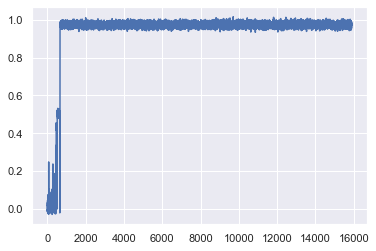

In [18]:
plt.plot(temp)

/home/franklin/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


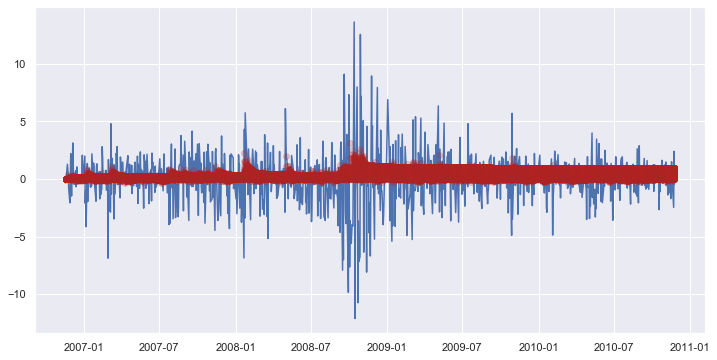

In [46]:
# OBS: se der tempo, transformar para y em nível e fazer mesmo gráfico com a volatilidade
plt.figure(figsize=(12,6))
plt.plot(y.index,y);
plt.plot(y.index,h.T*10, 'ob', alpha=0.2, color='firebrick');
# plt.plot(h.T[h.T!=0], color='firebrick', alpha=0.2);

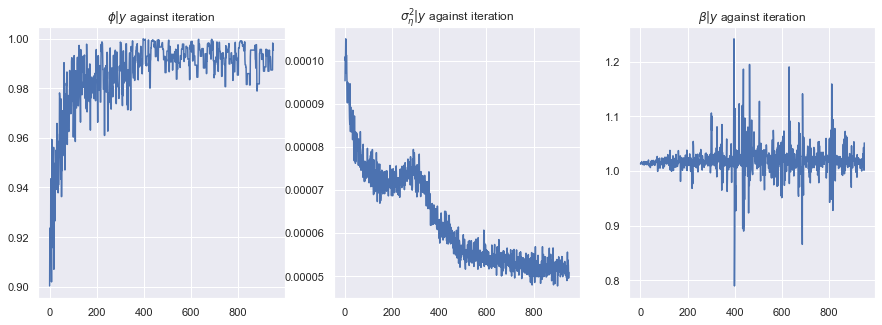

In [45]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,5))
sns.lineplot(x=list(range(N-50)),y=phi[50:], ax = ax[0])
sns.lineplot(x=list(range(N-50)),y=s2_n[50:], ax = ax[1])
sns.lineplot(x=list(range(N-50)),y=beta[50:], ax = ax[2])

ax[0].set_title(r'$\phi|y$ against iteration');
ax[1].set_title(r'$\sigma^2_{\eta}|y$ against iteration');
ax[2].set_title(r'$\beta|y$ against iteration');

In [53]:
# pd.DataFrame(h).to_csv('algo_base_h.csv')
# pd.DataFrame([phi, mu, s2_n, beta], index=['phi', 'mu', 's2_n', 'beta']).transpose().to_csv('algo_base_params.csv')